In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df_tran = pd.read_csv('../dataset/tran.txt',names=['primary-date','time','approximate-indicator','secondary-date','approximate-indicator',
  'transaction-ID','player','type','from-team','from-league','to-team','to-league','draft-type','draft-round','pick-number','info'])
df_playerid = pd.read_csv('../dataset/playerid_list.csv',names=['LASTNAME','FIRSTNAME','PLAYERID','DAVENPORTCODE','MLBCODE','player'],skiprows=1);
df_master = pd.read_csv('../dataset/Master.csv')
df_batting = pd.read_csv('../dataset/Batting.csv')
df_pitching = pd.read_csv('../dataset/Pitching.csv')
df_fielding = pd.read_csv('../dataset/Fielding.csv')
df_batstat = pd.read_csv('../dataset/war_daily_bat.txt')
df_pitchstat = pd.read_csv('../dataset/war_daily_pitch.txt')
pd.set_option('display.max_columns', 60)

# Data Cleanup
# Recontructing invalid dates
df_tran['primary-date'] = df_tran['primary-date'].astype('str')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})[0]{4}', r'\g<1>0101')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})(..)[0]{2}', r'\g<1>\g<2>01')

#Extracting only trades from transaction dataframe
df_tran = df_tran[df_tran['type'] == "T "]
df_tran = df_tran[df_tran['to-league'].isin(['AL','NL'])]
df_tran = df_tran[df_tran['from-league'].isin(['AL','NL'])]

df_tran['primary-date'] = pd.to_datetime(df_tran['primary-date'], format='%Y%m%d')
df_tran['tranYear'] = df_tran['primary-date'].apply(lambda x : int(x.year))

C:\Users\ANKIT\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Advanced Model

In [2]:
df_master['player_ID'] = df_master['bbrefID']
df_batstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_pitchstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_batting = pd.merge(df_batting,df_master[['playerID','retroID','birthYear']],on='playerID')
df_pitching = pd.merge(df_pitching,df_master[['playerID','retroID','birthYear']],on='playerID')
df_fielding = pd.merge(df_fielding,df_master[['playerID','retroID','birthYear']],on='playerID')
df_batting['age']= df_batting['yearID'] - df_batting['birthYear']
df_pitching['age']= df_pitching['yearID'] - df_pitching['birthYear']
df_fielding['age']= df_fielding['yearID'] - df_fielding['birthYear']

In [3]:
df_batstat_sort = df_batstat.sort('age')
df_batstat_sort = df_batstat_sort[pd.notnull(df_batstat_sort['age'])]
agedict = {}

#print df_batstat_sort.age
for index, row in df_batstat_sort.iterrows():
    if(row['age'] in agedict):
        agedict[row['age']].append(row['WAR'])
    else:
        agedict[row['age']] = [row['WAR']]

C:\Users\ANKIT\Anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [4]:
age = []
avg_WAR= []
i=0
for key in agedict:
    if (~np.isnan(key)):
        avg = np.nansum(agedict[key]) / float(len(agedict[key]))
        age.append(key)
        avg_WAR.append(avg)
        
age_df = pd.DataFrame({ 'Age' : age,'Average_WAR' : avg_WAR}).sort('Age')

C:\Users\ANKIT\Anaconda\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [5]:
#age_df
def getAvgWarForAge(age):
    return (age_df[(age_df['Age'] == age)]['Average_WAR']).iloc[0]

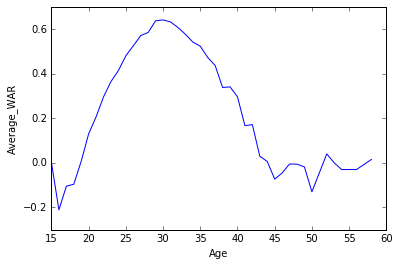

In [6]:
plt.xlabel("Age")
plt.ylabel("Average_WAR")
plt.plot(age_df.Age, age_df.Average_WAR);

In [7]:
def player_performance_projection(playerID, age):
    player_df = df_batstat[(df_batstat['retroID'] == playerID)]
    player_df_before = player_df[player_df['age']< age]
    diff = [0]
    for index,row in player_df_before.iterrows():
        diff.append(row['WAR'] - getAvgWarForAge(row['age']))
    mPerf  = np.mean(diff)    
    dict = {}
    for j in range(1,16):
        if age + j < 50:
            dict[j] = (getAvgWarForAge(age + j) + mPerf/j)
        else:
            dict[j] = 0
    return dict

In [8]:
def trade_value_year_projection(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        valDict = {}
        for index, row in td.iterrows():
            val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    continue
                birthYear = df_master['birthYear'][df_master['retroID'] == row['player']]
                if birthYear.empty:
                    continue
                birthYear = birthYear.iloc[0]
                age = row['tranYear'] - birthYear
                tempDict = player_performance_projection(row['player'],age)
                for i in range(1,16):
                    if i in valDict.keys():
                        valDict[i] += tempDict[i]
                    else:
                        valDict[i] = tempDict[i]
        player_vals.append(valDict)
    return player_vals

In [9]:
import scipy.optimize as optimize
def f(c):
    ret = 0.0
    for key, value in dict1.items():
        ret  += pow((1 - c[0]/100),key)*value
    for key, value in dict2.items():
        ret  -= pow((1 - c[1]/100),key)*value
    return abs(ret)

bnds = ((0, 100), (0, 100))

In [10]:
trade_val_projection_list = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    listnew = trade_value_year_projection(x,'WAR')
    dict1 = listnew[0]
    dict2 = listnew[1]
    result = optimize.minimize(f, (50, 50), method='TNC', bounds=bnds)
    trade_val_projection_list.append((x,result.x,result.fun))

KeyboardInterrupt: 

In [107]:
def trade_value_year_actual(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        valDict = {}
        for index, row in td.iterrows():
            val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(player_df['year_ID'] == row['tranYear'])]
                #instead need a df for the player after the trans year, and not just next, but all consecutive years
                for i in range(1,15):
                    player_df_year_next = player_df[(player_df['year_ID'] == (row['tranYear'] + i))]
                    if not player_df_year_next.empty:
                        # get the value of metric for each year after trade until 15 years else assume 0
                        t = float(player_df_year_next[metric].iloc[0])
                        #print(t)
                        if i in valDict.keys():
                            valDict[i] += t
                        else:
                            valDict[i] = t
                    else:
                        ## figure out a way to find war for these players
                        if i in valDict.keys():
                            valDict[i] += 0
                        else:
                            valDict[i] = 0
        player_vals.append(valDict)
    return player_vals

In [108]:
def f2(c,dict_1,dict_2):
    ret = 0.0
    for key, value in dict_1.items():
        ret  += pow((1 - c[0]/100),key)*value
    for key, value in dict_2.items():
        ret  -= pow((1 - c[1]/100),key)*value
    return abs(ret)

diff_list = [] 
for i in trade_val_projection_list:
    listnew = trade_value_year_actual(i[0],'WAR') #should come from projections instead of actual value
    act = f2( i[1], listnew[0], listnew[1])
    diff_list.append((i[0],act))

In [110]:
import pickle
with open("diff_list_2.pkl", "rb") as input_file:
    diff_list = pickle.load(input_file)

In [111]:
sList = sorted(diff_list,key=lambda x: x[1], reverse=True)

In [14]:
rank_df = pd.DataFrame(columns = ['Rank','Date','Team1','Team2','Players Team1','Player Team2','Trade Value Diff'])
k = 0
for i in sList:
    tranID = i[0]
    tran = df_tran[df_tran['transaction-ID'] == tranID]
    teams = tran['from-team'].unique()
    t1 = teams[0]
    t2 = teams[1]
    p1List = []
    p2List = []
    for index,row in tran.iterrows():
        pl = df_master[df_master['retroID'] == row['player']]
        if row['from-team'] == t1:
            p1List.append(''.join(pl['nameFirst'].values +" "+ pl['nameLast'].values))
        else:
            p2List.append(''.join(pl['nameFirst'].values + " " + pl['nameLast'].values))
    p1str = ','.join(p1List)
    p2str = ','.join(p2List)
    date = tran['primary-date'].iloc[0]
    rank_df.loc[k] = [int(k+1),date,t1,t2,p1str,p2str,i[1]]
    k += 1
    if (k == 100):
        break

In [15]:
rank_df

,Rank,Date,Team1,Team2,Players Team1,Player Team2,Trade Value Diff
0,1.0,1949-12-14,NY1,BSN,"Sid Gordon,Buddy Kerr,Willard Marshall,Red Webb","Eddie Stanky,Al Dark",8.103336
1,2.0,1959-12-06,CLE,CHA,"Minnie Minoso,Dick Brown,Don Ferrarese,Jake St...","John Romano,Bubba Phillips,Norm Cash",7.831614
2,3.0,1963-01-14,BAL,CHA,"Hoyt Wilhelm,Dave Nicholson,Pete Ward,Ron Hansen","Luis Aparicio,Al Smith",7.402284
3,4.0,1959-12-11,NYA,KC1,"Don Larsen,Hank Bauer,Norm Siebern,Marv Throne...","Roger Maris,Joe DeMaestri,Kent Hadley",7.368413
4,5.0,1946-09-30,PIT,BSN,"Bob Elliott,Hank Camelli","Billy Herman,Elmer Singleton,Stan Wentzel,Whit...",7.213203
5,6.0,1999-12-22,SDN,ATL,"Wally Joyner,Reggie Sanders,Quilvio Veras","Bret Boone,Ryan Klesko,Jason Shiell",7.159809
6,7.0,1904-12-26,BOS,SLA,",George Stone",Jesse Burkett,7.092150
7,8.0,1928-10-29,NY1,PHI,",Lefty O'Doul",Freddy Leach,6.990570
8,9.0,1997-11-18,TBA,PHI,Bobby Abreu,Kevin Stocker,6.815524
9,10.0,1928-11-07,CHN,BSN,",Socks Seibold,Percy Jones,Lou Legett,Freddie ...",Rogers Hornsby,6.604151


In [19]:
df_tran.head()


,primary-date,time,approximate-indicator,secondary-date,approximate-indicator,transaction-ID,player,type,from-team,from-league,to-team,to-league,draft-type,draft-round,pick-number,info,tranYear
32372,1968-12-10,NaN,NaN,NaN,NaN,72232,marel101,T,DET,AL,HOU,NL,NaN,NaN,NaN,NaN,1968
32373,1967-08-17,NaN,NaN,NaN,NaN,72232,mathe101,T,HOU,NL,DET,AL,NaN,NaN,NaN,NaN,1967
32374,1967-11-22,NaN,NaN,NaN,NaN,72232,gladf102,T,DET,AL,HOU,NL,NaN,NaN,NaN,NaN,1967
50583,1964-01-01,NaN,NaN,NaN,NaN,72241,steem101,T,CHN,NL,PHI,NL,NaN,NaN,NaN,NaN,1964
50584,1964-01-01,NaN,NaN,NaN,NaN,72241,Robert Baillargeon,T,PHI,NL,CHN,NL,NaN,NaN,NaN,NaN,1964


In [14]:
df_master


,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,player_ID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,NaN,NaN,NaN,David,Aardsma,David Allan,220.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01,aardsda01
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,NaN,NaN,NaN,Hank,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01,aaronha01
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,USA,GA,Atlanta,Tommie,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01,aaronto01
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,NaN,NaN,NaN,Don,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01,aasedo01
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,NaN,NaN,NaN,Andy,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01,abadan01
5,abadfe01,1985.0,12.0,17.0,D.R.,La Romana,La Romana,NaN,NaN,NaN,NaN,NaN,NaN,Fernando,Abad,Fernando Antonio,220.0,73.0,L,L,2010-07-28,2015-10-03,abadf001,abadfe01,abadfe01
6,abadijo01,1854.0,11.0,4.0,USA,PA,Philadelphia,1905.0,5.0,17.0,USA,NJ,Pemberton,John,Abadie,John W.,192.0,72.0,R,R,1875-04-26,1875-06-10,abadj101,abadijo01,abadijo01
7,abbated01,1877.0,4.0,15.0,USA,PA,Latrobe,1957.0,1.0,6.0,USA,FL,Fort Lauderdale,Ed,Abbaticchio,Edward James,170.0,71.0,R,R,1897-09-04,1910-09-15,abbae101,abbated01,abbated01
8,abbeybe01,1869.0,11.0,11.0,USA,VT,Essex,1962.0,6.0,11.0,USA,VT,Colchester,Bert,Abbey,Bert Wood,175.0,71.0,R,R,1892-06-14,1896-09-23,abbeb101,abbeybe01,abbeybe01
9,abbeych01,1866.0,10.0,14.0,USA,NE,Falls City,1926.0,4.0,27.0,USA,CA,San Francisco,Charlie,Abbey,Charles S.,169.0,68.0,L,L,1893-08-16,1897-08-19,abbec101,abbeych01,abbeych01


In [215]:
df_sort = df_tran.sort(['transaction-ID'])
df_sort

C:\Users\ANKIT\Anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,primary-date,time,approximate-indicator,secondary-date,approximate-indicator,transaction-ID,player,type,from-team,from-league,to-team,to-league,draft-type,draft-round,pick-number,info,tranYear
58667,1886-12-01 00:00:00,NaN,NaN,NaN,NaN,48198,NaN,T,PIT,NL,SL5,NL,NaN,NaN,NaN,$400,1886
58668,1886-12-01 00:00:00,NaN,NaN,NaN,NaN,48198,schoo101,T,PIT,NL,SL5,NL,NaN,NaN,NaN,NaN,1886
58669,1886-12-01 00:00:00,NaN,NaN,NaN,NaN,48198,mckia101,T,SL5,NL,PIT,NL,NaN,NaN,NaN,NaN,1886
58697,1887-04-21 00:00:00,NaN,NaN,NaN,NaN,48204,vanhg101,T,PIT,NL,CHN,NL,NaN,NaN,NaN,NaN,1887
58696,1887-04-21 00:00:00,NaN,NaN,NaN,NaN,48204,NaN,T,PIT,NL,CHN,NL,NaN,NaN,NaN,$2000,1887
58698,1887-04-21 00:00:00,NaN,NaN,NaN,NaN,48204,mccoj103,T,CHN,NL,PIT,NL,NaN,NaN,NaN,NaN,1887
58701,1887-10-20 00:00:00,NaN,NaN,NaN,NaN,48205,hinep101,T,WS8,NL,IN3,NL,NaN,NaN,NaN,NaN,1887
58700,1887-10-20 00:00:00,NaN,NaN,NaN,NaN,48205,gardg102,T,IN3,NL,WS8,NL,NaN,NaN,NaN,NaN,1887
58699,1887-10-20 00:00:00,NaN,NaN,NaN,NaN,48205,NaN,T,IN3,NL,WS8,NL,NaN,NaN,NaN,$,1887
58729,1888-05-01 00:00:00,NaN,NaN,NaN,NaN,48210,gardg102,T,WS8,NL,PHI,NL,NaN,NaN,NaN,NaN,1888


In [31]:
trans_ID = df_sort.iloc[0]['transaction-ID']
trans_ID

48198L

In [121]:
avg_age_diff = pd.DataFrame(columns = ['Trans-ID','Trans-Year','Avg_Age_Team1','Avg_Age_Team2','Avg_Age_diff','Sum_Age_diff','Team1', 'Team2'])
trans_ID = df_sort.iloc[0]['transaction-ID']
team1=[]
team2=[]
trans_yr=''
team1name=df_sort.iloc[0]['from-team']
team2name= ''
for i,row in df_sort.iterrows():
    if (trans_ID == row['transaction-ID']):
        if pd.isnull(row['player']):
            continue
        else:
            birthYear = df_master['birthYear'][df_master['retroID'] == row['player']]
            if birthYear.empty:
                continue
            birthYear = birthYear.iloc[0]
            trans_yr = row['tranYear']
            age = row['tranYear'] - birthYear
            #print age
            if team1name == row['from-team']:
                team1.append(age)
            else:
                team2name= row['from-team']
                team2.append(age)
    else:
        if len(team1)==0:
            t1avg =0
        else:
            t1avg = np.nansum(team1) / float(len(team1))
        if len(team2)==0:
            t2avg =0
        else:
            t2avg = np.nansum(team2) / float(len(team2))
        #print team1,team2
        Sum_Age_diff = abs(np.nansum(team1)-np.nansum(team2))
        df = [trans_ID,trans_yr, t1avg, t2avg, abs(t2avg-t1avg), Sum_Age_diff,team1name, team2name]
        avg_age_diff.loc[len(avg_age_diff)] = df
        trans_ID =  row['transaction-ID']
        team1name = row['from-team']
        team1=[]
        team2=[]
        birthYear = df_master['birthYear'][df_master['retroID'] == row['player']]
        if birthYear.empty:
            continue
        birthYear = birthYear.iloc[0]
        trans_yr = row['tranYear']
        age = row['tranYear'] - birthYear
        if team1name == row['from-team']:
            team1.append(age)
        else:
            team2name= row['from-team']
            team2.append(age)


In [209]:
df_sort['from-team'].unique()

array(['PIT', 'SL5', 'CHN', 'WS8', 'IN3', 'PHI', 'NY1', 'LS3', 'SLN',
       'BLN', 'BSN', 'BRO', 'WSN', 'CL4', 'CIN', 'CLE', 'BOS', 'DET',
       'WS1', 'CHA', 'NYA', 'SLA', 'PHA', 'MLN', 'BAL', 'KC1', 'SFN',
       'LAN', 'WS2', 'LAA', 'MIN', 'HOU', 'NYN', 'CAL', 'ATL', 'OAK',
       'SDN', 'KCA', 'MON', 'SE1', 'MIL', 'TEX', 'TOR', 'SEA', 'FLO',
       'COL', 'ANA', 'ARI', 'TBA', 'WAS', 'MIA'], dtype=object)

In [112]:
diff_list

[(72232, 0.099838831263362821),
 (72241, 0.0),
 (48198, 0.82404911493413768),
 (48204, 2.0525564567982597),
 (48205, 0.5992227400508543),
 (48210, 3.5103055308270554),
 (48212, 0.42805468100836119),
 (48220, 0.42489010600629812),
 (48226, 0.1964582391840316),
 (48229, 0.22306069290530944),
 (48230, 0.0),
 (48231, 1.0347018526768121),
 (48232, 6.0921442921715849),
 (48233, 0.5180881860938944),
 (48234, 4.2928511054203708),
 (48235, 4.732398757929821),
 (48236, 0.55721210539033561),
 (48237, 0.55481112846942693),
 (48238, 2.23258105397414),
 (48239, 0.6897105720559159),
 (66689, 0.5595340479454245),
 (66691, 0.54834431368367342),
 (48243, 0.40303736435759918),
 (48244, 2.2293091006085946),
 (48245, 1.4725904076749736),
 (48246, 0.031522490516613468),
 (48247, 0.0),
 (48248, 0.0075609396289071078),
 (48249, 0.18789767951544278),
 (48250, 0.70608493062472),
 (48251, 0.23259781128651263),
 (48252, 0.0055027699693727013),
 (48253, 0.026185564634554077),
 (48254, 2.7779791055417729),
 (48255,

In [235]:
er = df_tran[[df_tran['tranYear'] == 1987] & [df_tran['from-team'] == 'PIT']]

TypeError: unsupported operand type(s) for &: 'list' and 'list'

In [213]:
df_sort = df_tran.sort(['transaction-ID'])
no_of_trade = pd.DataFrame(columns = ['Year','PIT', 'SL5', 'CHN', 'WS8', 'IN3', 'PHI', 'NY1', 'LS3', 'SLN',
       'BLN', 'BSN', 'BRO', 'WSN', 'CL4', 'CIN', 'CLE', 'BOS', 'DET',
       'WS1', 'CHA', 'NYA', 'SLA', 'PHA', 'MLN', 'BAL', 'KC1', 'SFN',
       'LAN', 'WS2', 'LAA', 'MIN', 'HOU', 'NYN', 'CAL', 'ATL', 'OAK',
       'SDN', 'KCA', 'MON', 'SE1', 'MIL', 'TEX', 'TOR', 'SEA', 'FLO',
       'COL', 'ANA', 'ARI', 'TBA', 'WAS', 'MIA'] )
#no_of_trade = no_of_trade.set_index(['Year'])
#no_of_trade=no_of_trade.fillna(0.0, inplace=True)
td = df_sort['transaction-ID'].unique()
year = df_sort['tranYear'].unique()
no_of_trade['Year'] = year
no_of_trade=no_of_trade.fillna(0)
for x in range(0, len(td)):
    tran_id = df_sort[df_sort['transaction-ID']==td[x]].iloc[0]
    yr = no_of_trade[no_of_trade['Year'] == tran_id['tranYear']].iloc[0]
    yr[tran_id['from-team']] = yr[tran_id['from-team']] + 1;
    no_of_trade[tran_id['from-team']][no_of_trade['Year'] == tran_id['tranYear']] = yr[tran_id['from-team']]
    yr[tran_id['to-team']] = yr[tran_id['to-team']] + 1;
    no_of_trade[tran_id['to-team']][no_of_trade['Year'] == tran_id['tranYear']] = yr[tran_id['to-team']]

In [236]:
no_of_trade['PIT'][no_of_trade['Year']==1987].iloc[0]

9